# BEM Design de pale d'éolienne Off shore

## Imports

In [852]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import random
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.optimize import differential_evolution
from scipy.optimize import brentq

## Fonctions 

In [853]:
def f1(x, a):
    res = x - (4*a  - 1) * np.sqrt((1 - a)/(1 - 3*a))
    return(res)

In [854]:
def f2(x, a, a_prime, beta_i):
    return 8 * np.pi * x**2 * a_prime * np.sin(beta_i) /(Z * Cl_design * TSR_design * (1 - a))

In [855]:
def f3(a, c_r, k, beta_i, Cl, epsilon):
    #print(f'tan_betai{np.tan(beta_i)}')
    return a /(1 - a) - Z * c_r * Cl * np.cos(beta_i) * (1 + epsilon * np.tan(beta_i)) / (8 * np.pi * k * np.sin(beta_i)**2)

In [856]:
def f4(a_prime, c_r, k, beta_i, Cl, epsilon):
    #print(f'cos_betai{np.cos(beta_i)}')
    return a_prime /(1 + a_prime) - Z * c_r * Cl * (1 - epsilon / np.tan(beta_i)) / (8 * np.pi * k * np.cos(beta_i))

In [857]:
def Cl(alpha, m, b):
    if -10 < alpha < 10:
        return m * alpha + b
    else:
        return m * alpha + b
        print('angle hors de la plage de modélisation')

In [858]:
def Cd(alpha, coefficients):
    poly_model = np.poly1d(coefficients)
    return(poly_model(alpha))

In [859]:
def shape(corde, beta_i, r):
    X_upper = data_shape['x/c upper'] * corde
    Y_upper = data_shape['y/c upper'] * corde
    X_lower = data_shape['x/c lower'] * corde
    Y_lower = data_shape['y/c lower'] * corde
    Z = [r for k in range(len(X_upper))]
    return X_upper, Y_upper, X_lower, Y_lower, Z

## Lecture des données

In [860]:
#le shape de la pale
file_shape = "NACA64618.csv"
column_names_shape = ["x/c upper", "y/c upper", "x/c lower", "y/c lower"]
data_shape = pd.read_csv(file_shape, delimiter="\t", skiprows=3, names=column_names_shape)
print('Shape')
print(data_shape.head())

#les Cl et Cd
file_Cl_Cd = 'ClCdNACA64618.csv'
column_names_ClCd = ["AoA1", "C_L", "AoA2", "C_D"]
data_ClCd = pd.read_csv(file_Cl_Cd, delim_whitespace= True, skiprows=3, names=column_names_ClCd)
print('ClCd')
print(data_ClCd.head())

Shape
   x/c upper  y/c upper  x/c lower  y/c lower
0   0.000000   0.006827   0.000000   0.006827
1   0.000207   0.008519   0.000067   0.005155
2   0.000502   0.010217   0.000093   0.003482
3   0.000928   0.011917   0.000316   0.001837
4   0.001492   0.013609   0.000679   0.000216
ClCd
   AoA1      C_L  AoA2      C_D
0 -25.0 -0.85475 -25.0  0.23047
1 -24.0 -1.06740 -24.0  0.16643
2 -23.0 -1.34550 -23.0  0.10596
3 -22.0 -1.45030 -22.0  0.07824
4 -21.0 -1.49570 -21.0  0.05985


## Affichage des données

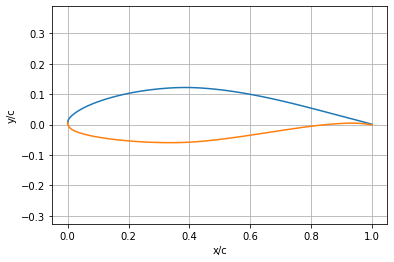

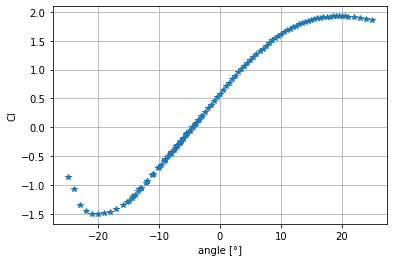

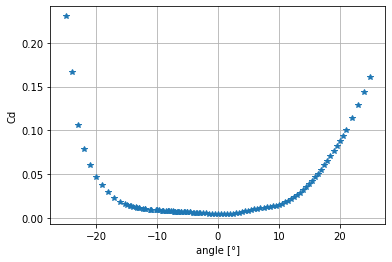

In [861]:
# Shape de la pale
plt.figure()
plt.plot(data_shape['x/c upper'], data_shape['y/c upper'])
plt.plot(data_shape['x/c lower'], data_shape['y/c lower'])
plt.grid()
plt.axis('equal')
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.show()

# Courbes Cl et Cd
plt.figure()
plt.plot(data_ClCd['AoA1'], data_ClCd['C_L'], '*')
plt.grid()
plt.xlabel('angle [°]')
plt.ylabel('Cl')
plt.show()

plt.figure()
plt.plot(data_ClCd['AoA1'], data_ClCd['C_D'], '*')
plt.grid()
plt.xlabel('angle [°]')
plt.ylabel('Cd')
plt.show()

## Données d'entrée du problème 

In [862]:
U_design = 12    # Vitesse nominale du vent [m/s]
D = 126          # diamètre [m]
R = D / 2        # rayon [m]
Aire_turb = np.pi * R**2 #aire de la turbine [m2]
Z = 3            # nombre de pales
TSR_design = 7.5        # Tip speed ratio
rho = 1.23       #densité air [kg/m3]

In [863]:
nb_sections = 55 #55 c'est parfait  # nombre de sections de la pale d'éolienne

## Calculs préliminaires

In [864]:
## Reynolds
mu = 1.48E-5
omega = TSR_design * U_design / R
V_ref = np.sqrt(U_design**2 + (omega * 0.7 * R)**2)
L_ref = 2

Re = V_ref * L_ref / mu
print('Reynolds =', Re)
print(V_ref)

Reynolds = 8666577.699904846
64.13267497929586


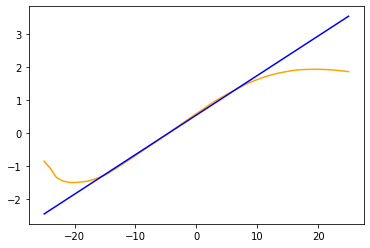

In [865]:
## Modélisation de Cl sur les plages de fonctionnement:
alfa_bounds = (-10, 10)
mask = (data_ClCd['AoA1'] >= alfa_bounds[0]) & (data_ClCd['AoA1'] <= alfa_bounds[1])

x_filtered = data_ClCd['AoA1'][mask]
y_filtered = data_ClCd['C_L'][mask]

#Calcul des coefficients (Cl= mx + b)
m, b = np.polyfit(x_filtered, y_filtered, 1)
Cl_pred = m * data_ClCd['AoA1'] + b

plt.figure()
plt.plot(data_ClCd['AoA1'], data_ClCd['C_L'], c='orange')
plt.plot(data_ClCd['AoA1'], Cl_pred, c='blue')
plt.show()

#On en déduit une fonction de calcul de Cl, voir partie fonction


In [866]:
print(m,b)

0.11963593677570866 0.5399833674946647


coeff: [ 1.65422609e-12 -4.98218825e-11 -1.12156161e-09  2.99901045e-08
  5.08328177e-07 -1.82398732e-06  1.92032700e-05  2.32120317e-04
  5.78104761e-03]


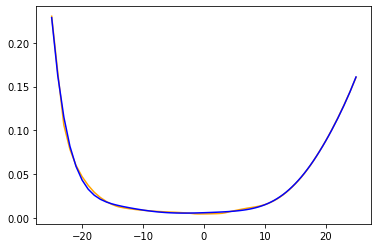

In [867]:
## Modélisation de Cd sur les plages de fonctionnement:

# Calcul des coefficients de la droite de régression linéaire (Cl= cx**2 + dx + e)
coefficients = np.polyfit(data_ClCd['AoA1'], data_ClCd['C_D'], 8)
print('coeff:', coefficients)
poly_model = np.poly1d(coefficients)
Cd_pred = poly_model(data_ClCd['AoA1'])

plt.figure()
plt.plot(data_ClCd['AoA1'], data_ClCd['C_D'], c='orange')
plt.plot(data_ClCd['AoA1'], Cd_pred, c='blue')
plt.show()

#On en déduit une fonction de calcul de Cd, voir partie fonction

# Partie 1 : Flux non visqueux

In [868]:
#Découpage de la pale en sections, à refaire !
#r_R_turb = [0.2, 0.317, 0.447, 0.496, 0.600, 0.652, 0.753, 0.8, 0.883, 0.946]
r_R_turb = np.linspace(0.2, 1, nb_sections)
r_turb = [r_r * R for r_r in r_R_turb]

In [869]:
X_turb = [omega * r_r * R / U_design for r_r in r_R_turb]
print('x_min =', X_turb[0])
print('x_max = ', X_turb[-1])

x_min = 1.5000000000000002
x_max =  7.5


In [870]:
#Calcul des a
A_turb = []

for x in X_turb:
    #Fixer un des arguments à une valeur spécifique en utilisant une fonction lambda
    f_fixed = lambda a: f1(x, a)

    # Trouver la valeur de a qui annule la fonction f_fixed dans l'intervalle [0, 1/3]
    sol = root_scalar(f_fixed, bracket=[0, 0.33332])
    A_turb += [sol.root]
#print('A_turb = ', A_turb)

In [871]:
#Calcul des a'
A_prime_turb = [(1 - 3*a)/ (4*a - 1) for a in A_turb]

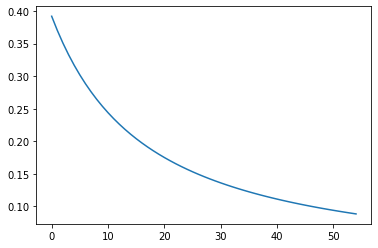

In [872]:
#Calcul des beta
Beta_turb = [np.arctan(1/x) for x in X_turb]
Beta_i_turb = [np.arctan((1 - A_turb[k]) / (X_turb[k]* (1 + A_prime_turb[k]))) for k in range(len(X_turb))]

plt.figure()
plt.plot(Beta_i_turb)
plt.show()

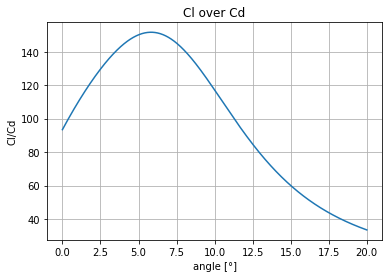

Alpha design = 5.8258258258258255
Cl design = 1.2369614976594538
Cd design = 0.008158271518132778
epsilon_max = 0.029873453917344583
epsilon_min = 0.006595412657200443


In [899]:
#Calcul du alpha_design
Alpha = np.linspace(0,20, 1000)
Cl_Cd = [Cl(alpha, m, b)/Cd(alpha, coefficients) for alpha in Alpha]
E = [Cd(alpha, coefficients)/Cl(alpha, m, b) for alpha in Alpha]
plt.figure()
plt.plot(Alpha, Cl_Cd)
plt.grid()
plt.xlabel('angle [°]')
plt.ylabel('Cl/Cd')
plt.title('Cl over Cd')
plt.show()

indice_max = Cl_Cd.index(max(Cl_Cd))
alpha_design = Alpha[indice_max]
Cl_design = Cl(Alpha[indice_max], m, b)
Cd_design = Cd(Alpha[indice_max], coefficients)
print('Alpha design =', alpha_design)
print('Cl design =', Cl_design)
print('Cd design =', Cd_design)
print('epsilon_max =', max(E))
print('epsilon_min =', min(E))

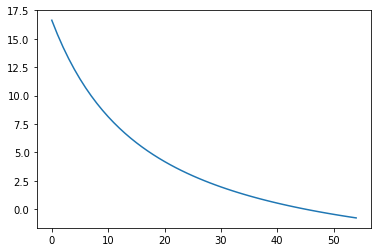

Psi min = -0.7627302467648609
Psi max =  16.634219191469132


In [874]:
#calcul de psi
Psi_turb = [beta_i - np.radians(alpha_design) for beta_i in Beta_i_turb]
Psi_turb_deg = np.degrees(Psi_turb)

plt.figure()
plt.plot(Psi_turb_deg)
plt.show()

print('Psi min =', min(Psi_turb_deg))
print('Psi max = ', max(Psi_turb_deg))

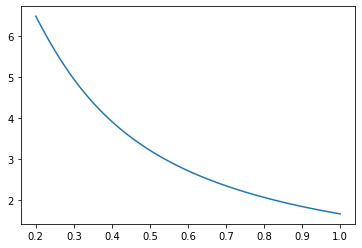

corde root = 6.473072613055129
corde tip = 1.6648585237006002


In [875]:
#Calcul de c/r, utilisation de f2, voir partie fonction
C_R_turb = [f2(X_turb[k], A_turb[k], A_prime_turb[k], Beta_i_turb[k]) for k in range(len(X_turb))]
C_turb = [C_R_turb[k] * R for k in range(len(C_R_turb))]

plt.figure()
plt.plot(r_R_turb, C_turb)
plt.show()
print('corde root =', max(C_turb))
print('corde tip =', min(C_turb))

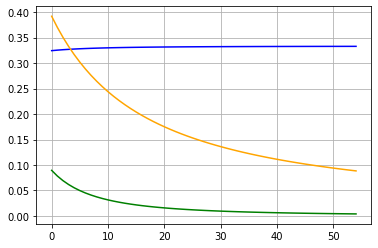

In [876]:
plt.figure()
plt.plot(A_turb, c='blue')
plt.plot(A_prime_turb, c = 'green')
plt.plot(Beta_i_turb, c = 'orange')
plt.grid()
plt.show()

## Modélisation 3D

In [877]:
# dico_shapes = {'shape_0':[[X_upper], [Y_upper], [X_lower], [Y_lower], [Z_upper], [Z_lower]]}
n_shape = len(X_turb)
dico_shapes = {'shape_' + str(i): None for i in range(n_shape)}

for i in range(n_shape):
    dico_shapes['shape_' + str(i)] = []
    X_upper = data_shape['x/c upper'].values * C_turb[i]
    Y_upper = data_shape['y/c upper'].values * C_turb[i]
    X_lower = data_shape['x/c lower'].values * C_turb[i]
    Y_lower = data_shape['y/c lower'].values * C_turb[i]
    #on fait les rotations de beta_i
    X_upper_rot = X_upper * np.cos(Psi_turb[i]) - Y_upper * np.sin(Psi_turb[i])
    Y_upper_rot = X_upper * np.sin(Psi_turb[i]) + Y_upper * np.cos(Psi_turb[i])
    X_lower_rot = X_lower * np.cos(Psi_turb[i]) - Y_lower * np.sin(Psi_turb[i])
    Y_lower_rot = X_lower * np.sin(Psi_turb[i]) + Y_lower * np.cos(Psi_turb[i])
    
    
    Z_upper = [r_turb[i] for k in range(len(X_upper))]
    Z_lower = [r_turb[i] for k in range(len(X_lower))]
    dico_shapes['shape_' + str(i)].append(X_upper_rot)
    dico_shapes['shape_' + str(i)].append(Y_upper_rot)
    dico_shapes['shape_' + str(i)].append(X_lower_rot)
    dico_shapes['shape_' + str(i)].append(Y_lower_rot)
    dico_shapes['shape_' + str(i)].append(np.array(Z_upper))
    dico_shapes['shape_' + str(i)].append(np.array(Z_lower))
#print(dico_shapes['shape_3'])

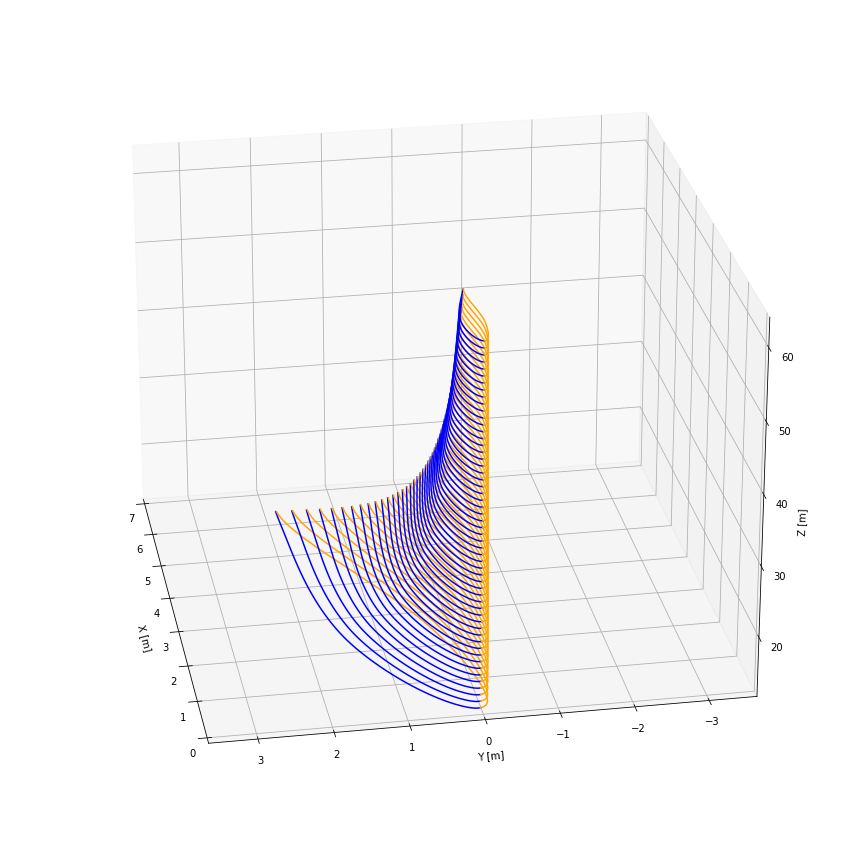

In [878]:
# Affichage 3D
fig = plt.figure(figsize= (15,30))
ax = fig.add_subplot(111, projection='3d')

# Tracer les surfaces pour chaque section de la pale
for key in dico_shapes.keys():
    #generation d'une couleur aléatoire
    random_color = mcolors.to_hex(random.choice(list(mcolors.TABLEAU_COLORS.values())))
    c_upper = 'blue'
    c_lower = 'orange'
    x = dico_shapes[key][0] 
    y = dico_shapes[key][1] 
    z = dico_shapes[key][4] 
    ax.plot(x, y, z, color=c_upper)
    x = dico_shapes[key][2]
    y = dico_shapes[key][3]
    z = dico_shapes[key][5]
    ax.plot(x, y, z, color=c_lower)
# Ajouter des détails, des annotations, etc. si nécessaire
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# Afficher le modèle 3D
#ax.set_box_aspect([1,1,1])
ax.set_xlim([0, 7])
#ax.set_xlim([0, 62])
ax.set_ylim([-3.5, 3.5])
#ax.set_ylim([-31,31])
ax.view_init(elev=25, azim=-190)
plt.show()

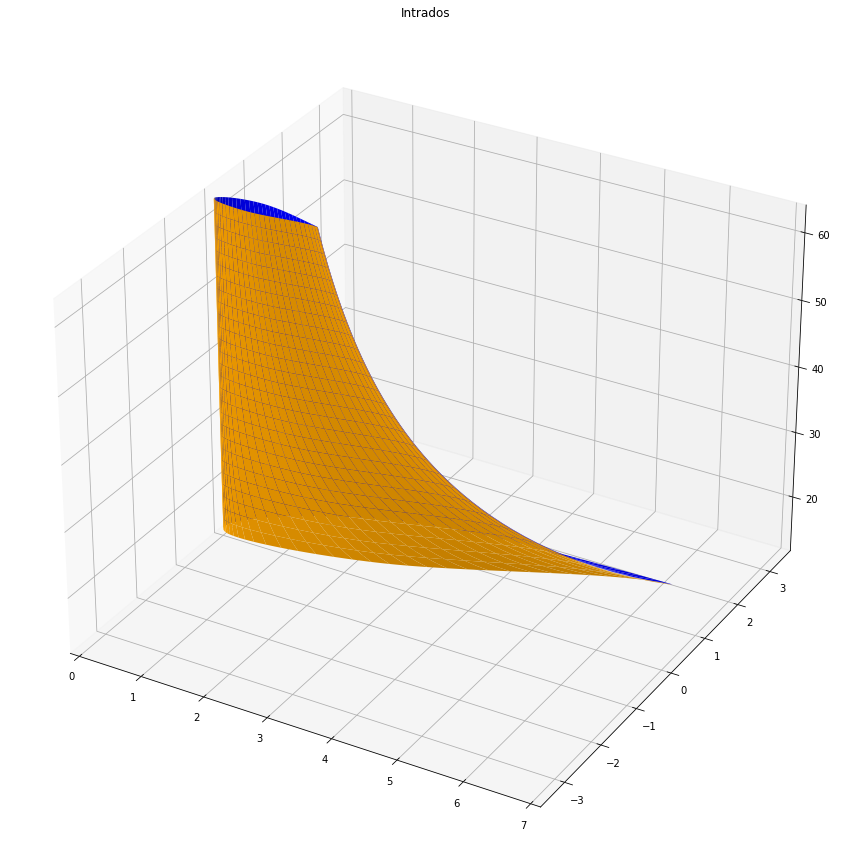

In [879]:
# Affichage 3D, surfaces
# dans ce plot on fait deux surfaaces, l'extrados et l'intrados de la pale
X_extra = []
Y_extra = []
Z_extra = []

X_intra = []
Y_intra = []
Z_intra = []

for key in dico_shapes.keys():
    X_extra.append(dico_shapes[key][0]) 
    Y_extra.append(dico_shapes[key][1])
    Z_extra.append(dico_shapes[key][4])
    X_intra.append(dico_shapes[key][2]) 
    Y_intra.append(dico_shapes[key][3]) 
    Z_intra.append(dico_shapes[key][5])

X_extra = np.array(X_extra)
Y_extra = np.array(Y_extra)
Z_extra = np.array(Z_extra)
X_intra = np.array(X_intra)
Y_intra = np.array(Y_intra)
Z_intra = np.array(Z_intra)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(111, projection='3d')
#on plot l'extrados
surf1 = ax.plot_surface(X_extra, Y_extra, Z_extra, color = 'blue', shade = True)
ax.set_title('Extrados')
#on plot l'intrados
surf2 = ax.plot_surface(X_intra, Y_intra, Z_intra, color = 'orange', shade = True)
ax.set_title('Intrados')


# Afficher la figure
ax.set_xlim3d([0, 7])
ax.set_ylim3d([-3.5, 3.5])
#ax.view_init(elev=-90, azim=-190)
plt.show()

## Evaluation du nombre de sections par influence sur le Cp

In [880]:
Cp = 0
dx = X_turb[1] - X_turb[0]
for k in range(1, len(X_turb)):
    Cp = Cp + (8 / TSR_design**2) * (1 - A_turb[k]) * A_prime_turb[k] * X_turb[k]**3 * dx
    dx = X_turb[k] - X_turb[k-1]
print('Cp_{} ='.format(nb_sections), Cp)    

    
    

Cp_55 = 0.5688953887314091


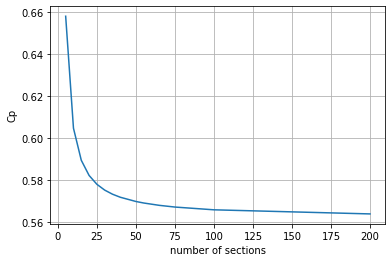

Cp asymptote =  0.5636983785163762


In [881]:
Sections = [50, 75, 40, 100, 55, 5, 20, 25, 35, 10, 15, 65, 30, 200]
Cps = [0.5696230926660567,
       0.5669678416080598,
       0.5716381485615423,
       0.5656535091746817,
       0.5688953887314091,
       0.6578650453099828,
       0.5820286958975027,
       0.5778081215344081,
       0.5730900609758051,
       0.6045249335143579,
       0.5892621038030303,
       0.5677810459211284,
       0.5750424833226534,
       0.5636983785163762] #respecte l'ordre de Sections

# Combinez les deux listes en une liste de paires (section, Cp)
combined = list(zip(Sections, Cps))

# Triez la liste combinée en fonction des sections
sorted_combined = sorted(combined, key=lambda x: x[0])

# Séparez les sections triées et les valeurs Cp triées
sorted_sections, sorted_Cps = zip(*sorted_combined)

plt.figure()
plt.plot(sorted_sections, sorted_Cps)
plt.xlabel('number of sections')
plt.ylabel('Cp')
plt.grid()
plt.show()
print('Cp asymptote = ', sorted_Cps[-1])

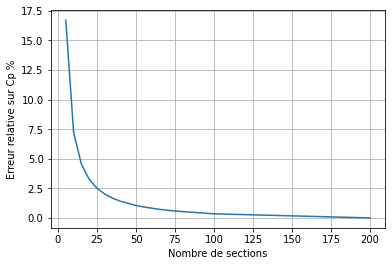

Nb de sections (5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 65, 75, 100, 200)
Erreur relative % [16.71, 7.24, 4.54, 3.25, 2.5, 2.01, 1.67, 1.41, 1.05, 0.92, 0.72, 0.58, 0.35, 0.0]


In [882]:
# On pose Cp_200 comme la référence
ref = sorted_Cps[-1]
erreurCp = [(np.abs(sorted_Cps[k] - ref ))  * 100 / ref for k in range(len(sorted_Cps))]

plt.figure()
plt.plot(sorted_sections, erreurCp)
plt.xlabel('Nombre de sections')
plt.ylabel('Erreur relative sur Cp %')
plt.grid()
plt.show()

erreurs_arrondies = [round(x, 2) for x in erreurCp]
print('Nb de sections', sorted_sections)
print('Erreur relative %', erreurs_arrondies)


# Partie 2 : Flux visqueux

##### Le but de cette partie est de changer légèrement la géométrie ($ \beta_{i} , \alpha$) en prennant en compte la viscosité 

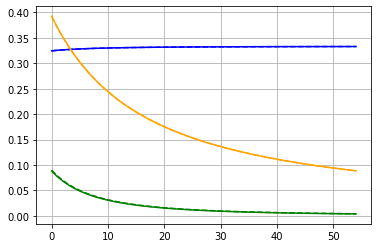

In [883]:
#certaines valeurs ne changent pas en écoulement réel (RF)
X_turb_RF = X_turb
r_R_turb_RF = r_R_turb
F_glau_vect = []
# il reste à trouver alpha et a, a' et beta_i de chaque section 
A_turb_RF = np.zeros(nb_sections)
A_prime_turb_RF = np.zeros(nb_sections)
Beta_i_turb_RF = np.zeros(nb_sections)
for k in range(len(C_turb)):
    epsilon_design = Cd_design / Cl_design
    
    c_glauert = C_turb[k]
    F_glauert = Z * c_glauert * Cl_design / r_turb[k]
    F_glau_vect = F_glau_vect + [F_glauert]
    LSR = X_turb[k] #local speed ratio


    # Définir les fonctions à minimiser, x = [a, a', beta_i]
    def objective_function1(x):
        a, a_prime, beta_i = x[0], x[1], x[2]
        return (a / (1 - a)) - ((F_glauert * np.cos(beta_i) *  (1 + epsilon_design * np.tan(beta_i))) / (8 * np.pi * np.sin(beta_i)**2))

    def objective_function2(x):
        a, a_prime, beta_i = x[0], x[1], x[2]
        return (a_prime / (1 + a_prime)) - ((F_glauert *  (1 - epsilon_design / np.tan(beta_i))) / (8 * np.pi * np.cos(beta_i)))

    def objective_function3(x):
        a, a_prime, beta_i = x[0], x[1], x[2]
        return np.tan(beta_i) - (1 - a)/(LSR * (1 + a_prime))

    def objective_sum(x):
        return np.sqrt(np.abs(objective_function1(x))**2 + np.abs(objective_function2(x))**2 + np.abs(objective_function3(x))**2)

    # Définir les bornes des variables
    #bounds = [(0.25, 0.333333), (0, 2), (0.05, 0.5) ]  
    bounds = [(0.25, 0.333333), (0, 20), (0.05, 1)]  


    # Point de départ initial
    x0 = [A_turb[k], A_prime_turb[k], Beta_i_turb[k]]

    # Minimisation de la fonction objective avec les contraintes
    #result = minimize(objective_sum, x0, bounds=bounds, method='differential_evolution')
    result = differential_evolution(objective_sum, bounds = bounds)
    
    A_turb_RF[k] = result.x[0]
    A_prime_turb_RF[k] = result.x[1]
    Beta_i_turb_RF[k] = result.x[2]
    # Affichage des résultats
    #print(f'section : {k}')

#print('A_turb_RF :', A_turb_RF)
#print('A_prime_turb_RF :', A_prime_turb_RF)
#print('Beta_i_turb_RF :', Beta_i_turb_RF)
plt.figure()
plt.plot(A_turb, c='blue', linestyle='--')
plt.plot(A_turb_RF, c='blue')
plt.plot(A_prime_turb, c = 'green', linestyle='--')
plt.plot(A_prime_turb_RF, c = 'green')
plt.plot(Beta_i_turb, c = 'orange', linestyle='--')
plt.plot(Beta_i_turb_RF, c = 'orange')
plt.grid()
plt.show()

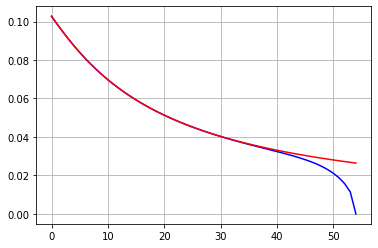

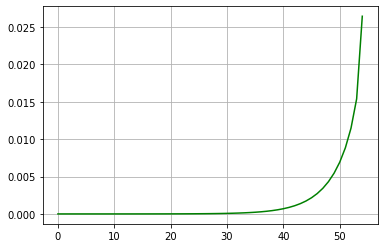

In [884]:
#Calcul de k : tip loss factor et caclul de C/r
f_RF = [(Z * R)/(2 * r_R_turb_RF[k] * R * np.tan(Beta_i_turb_RF[k])) - 0.5 for k in range(nb_sections)]
K_RF = [2 * np.arccos(np.cosh(r_R_turb_RF[k] * f_RF[k]) / np.cosh(f_RF[k])) / np.pi for k in range(nb_sections)]
F_RF = [x * y for x, y in zip(K_RF, F_glau_vect)]
C_R_turb_RF = [F_RF[k] * r_R_turb_RF[k] /(Z * Cl_design) for k in range(nb_sections)]

plt.figure()
plt.plot(C_R_turb_RF, color='blue')
plt.plot(C_R_turb, color='red')
plt.grid()
plt.show()

dif_c_R = [C_R_turb[k] - C_R_turb_RF[k] for k in range(nb_sections)]
plt.figure()
plt.plot(dif_c_R, color='green')
plt.grid()
plt.show()

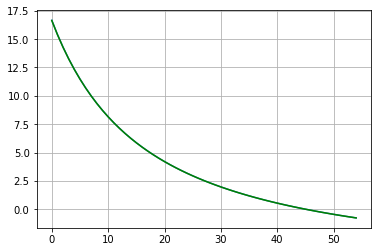

In [885]:
#calcul de psi
Psi_turb_RF = [beta_i - np.radians(alpha_design) for beta_i in Beta_i_turb_RF]
plt.figure()
plt.plot(np.degrees(Psi_turb_RF))
plt.plot(Psi_turb_deg, color='green')
plt.grid()
plt.show()

In [886]:
#Calcul du Cp
Cp_RF = 0
dx = X_turb_RF[1] - X_turb_RF[0]
for k in range(1, len(X_turb)):
    Cp_RF = Cp_RF + (8 / TSR_design**2) * (1 - A_turb_RF[k]) * A_prime_turb_RF[k] * X_turb_RF[k]**3 * dx
    dx = X_turb_RF[k] - X_turb_RF[k-1]
print('Cp_RF_{} ='.format(nb_sections), Cp_RF) 

Cp_RF_55 = 0.5389912388039424


# Partie 3 : Etude du comportement hors des conditions optimales

In [887]:
#Etude du Cp hors du TSR de design,
delta_TSR = 0.1 #on va de TSR-2 à TSR+2 par pas de delta_TSR
TSR_OD_neg = [TSR_design - k * delta_TSR for k in range(1, 21)] #OD pour "off-design"
Cps_OD_neg = []
P_OD_neg = []
TSR_OD_pos = [TSR_design + k * delta_TSR for k in range(1, 21)]
Cps_OD_pos = []
P_OD_pos = []

#On recalcule les Vecteur a a' et beta_i et on en déduit CP pour les TSR inférieurs au TSR design
Beta_i_OD = Beta_i_turb_RF
A_turb_OD = A_turb_RF
A_prime_turb_OD = A_prime_turb_RF
Cl_turb_OD = np.zeros_like(A_turb_OD)
Cd_turb_OD = np.zeros_like(A_turb_OD)
for TSR in TSR_OD_neg: 
    #on calcule directement a et a' on en déduit un beta_i et on reboucle jusqu'à avoir un beta_i stable
    X_turb_OD = [X_turb_RF[k] * TSR / TSR_design for k in range(len(X_turb_RF))]
    for j in range(len(A_turb_OD)):
        err_beta_i = 1
        a, a_prime, c_r, beta_i, k, psi = A_turb_OD[j], A_prime_turb_OD[j], C_R_turb_RF[j], Beta_i_OD[j], K_RF[j], Psi_turb_RF[j]
        alfa = np.rad2deg(beta_i - psi)
        while err_beta_i > 1E-3 :
            alfa = np.rad2deg(beta_i - psi)
            #calcul de Cl
            Cl_turb_OD[j] = Cl(alfa, 0.11963593677570866, 0.5399833674946647)
            #calcul de Cd et de epsilon
            Cd_turb_OD[j] = Cd(alfa, [1.65422609e-12, -4.98218825e-11, -1.12156161e-09, 2.99901045e-08, 5.08328177e-07, -1.82398732e-06, 1.92032700e-05, 2.32120317e-04, 5.78104761e-03])
            epsilon = Cd_turb_OD[j]/Cl_turb_OD[j]
            #calcul de a
            #Fixer un des arguments à une valeur spécifique en utilisant une fonction lambda
            f_fixed1 = lambda a_find: f3(a_find, c_r, k, beta_i, Cl_turb_OD[j], epsilon)
            # Trouver la valeur de a qui annule la fonction f_fixed dans l'intervalle [0, 1/3]
            #sol = root_scalar(f_fixed1, bracket=[0, 0.33332]) #bracket=[0, 0.33332]
            sol = brentq(f_fixed1, 0, 0.33332)
            #a = sol.root
            a = sol
            #calcul de a'
            f_fixed2 = lambda a_prime_find: f4(a_prime_find, c_r, k, beta_i, Cl_turb_OD[j], epsilon)
            sol2 = root_scalar(f_fixed2, bracket = [0, 0.1]) #
            a_prime = sol2.root
            #print('minif2 = ', sol2.fun)
            #calcul de beta_i
            beta_i_new = np.arctan((1 - a)/(X_turb_OD[j] * (1 + a_prime)))
            err_beta_i = np.abs(beta_i_new - beta_i)
            #print("beta i , err :",(j, beta_i, err_beta_i))
            beta_i = max(0.0001, beta_i_new)
            A_turb_OD[j], A_prime_turb_OD[j], Beta_i_OD[j] = a, a_prime, beta_i
        #print(f'section faite {j}, a = {a}, a\'={a_prime}')
    #calcul du Cp, pour varier le TSR on fixe le Omega
    P_wind = 0.5 * rho * (omega * R / TSR)**3 * Aire_turb
    P_turb = 0
    Cp = 0
    dr = r_turb[1] - r_turb[0]
    dx = X_turb_OD[1] - X_turb_OD[0]
    for l in range(1, len(X_turb)):
        P_turb = P_turb + 4 * np.pi * rho * (omega * R / TSR) * omega**2 * (1 - A_turb_OD[l]) * A_prime_turb_OD[l] * K_RF[l] * r_turb[l]**3 * dr 
        Cp = Cp + 8 * (1 - A_turb_OD[l]) * A_prime_turb_OD[l] * X_turb_OD[l] * dx / TSR**2
        dr = r_turb[l] - r_turb[l-1]
        dx = X_turb_OD[l] - X_turb_OD[l-1]
    P_OD_neg += [P_turb]
    Cps_OD_neg.append(Cp)
    print('TSR', TSR)
    #print('beta_i', max(Beta_i_OD))
                                   

TSR 7.4
TSR 7.3
TSR 7.2
TSR 7.1
TSR 7.0
TSR 6.9
TSR 6.8
TSR

<ipython-input-855-850fa2543598>:3: RuntimeWarning: invalid value encountered in scalar divide
  return a /(1 - a) - Z * c_r * Cl * np.cos(beta_i) * (1 + epsilon * np.tan(beta_i)) / (8 * np.pi * k * np.sin(beta_i)**2)


 6.7
TSR 6.6
TSR 6.5
TSR 6.4
TSR 6.3
TSR 6.2
TSR 6.1
TSR 6.0
TSR 5.9
TSR 5.8
TSR 5.7
TSR 5.6
TSR 5.5


In [888]:
alfa

11.0661096613817

In [902]:
#On recalcule les Vecteur a a' et beta_i et on en déduit CP pour les TSR supérieurs au TSR design
Beta_i_OD = Beta_i_turb_RF
A_turb_OD = A_turb_RF
A_prime_turb_OD = A_prime_turb_RF
Cl_turb_OD = np.zeros_like(A_turb_OD)
Cd_turb_OD = np.zeros_like(A_turb_OD)
for TSR in TSR_OD_pos: 
    #on calcule directement a et a' on en déduit un beta_i et on reboucle jusqu'à avoir un beta_i stable
    X_turb_OD = [X_turb_RF[k] * TSR / TSR_design for k in range(len(X_turb_RF))]
    for j in range(len(A_turb_OD)):
        err_beta_i = 1
        a, a_prime, c_r, beta_i, k, psi = A_turb_OD[j], A_prime_turb_OD[j], C_R_turb_RF[j], Beta_i_OD[j], K_RF[j], Psi_turb_RF[j]
        while err_beta_i > 1E-3 :
            alfa = np.rad2deg(beta_i - psi)
            #calcul de Cl
            Cl_turb_OD[j] = Cl(alfa, 0.11963593677570866, 0.5399833674946647)
            #calcul de Cd et de epsilon
            Cd_turb_OD[j] = Cd(alfa, [1.65422609e-12, -4.98218825e-11, -1.12156161e-09, 2.99901045e-08, 5.08328177e-07, -1.82398732e-06, 1.92032700e-05, 2.32120317e-04, 5.78104761e-03])
            epsilon = Cd_turb_OD[j]/Cl_turb_OD[j]
            #calcul de a
            #Fixer un des arguments à une valeur spécifique en utilisant une fonction lambda
            f_fixed1 = lambda a_find: f3(a_find, c_r, k, beta_i, Cl_turb_OD[j], epsilon)
            # Trouver la valeur de a qui annule la fonction f_fixed dans l'intervalle [0, 1/3]
            #sol = root_scalar(f_fixed1, bracket=[0, 0.33332]) #bracket=[0, 0.33332]
            try:
                sol = brentq(f_fixed1, 0, 0.33332)
                #a = sol.root
                a = sol
            except ValueError:
                print('echec brentq')
            #calcul de a'
            f_fixed2 = lambda a_prime_find: f4(a_prime_find, c_r, k, beta_i, Cl_turb_OD[j], epsilon)
            try:
                sol2 = root_scalar(f_fixed2, bracket = [0, 0.1]) #
                a_prime = sol2.root
            except ValueError:
                print('echec root_scalar')
            #print('minif2 = ', sol2.fun)
            #calcul de beta_i
            beta_i_new = np.arctan((1 - a)/(X_turb_OD[j] * (1 + a_prime)))
            err_beta_i = np.abs(beta_i_new - beta_i)
            #print("beta i , err :",(j, beta_i, err_beta_i))
            beta_i = max(0.0001, beta_i_new)
            A_turb_OD[j], A_prime_turb_OD[j], Beta_i_OD[j] = a, a_prime, beta_i
        #print(f'section faite {j}, a = {a}, a\'={a_prime}')
    #calcul du Cp, pour varier le TSR on fixe le Omega
    P_wind = 0.5 * rho * (omega * R / TSR)**3 * Aire_turb
    P_turb = 0
    Cp = 0
    dx = X_turb_OD[1] - X_turb_OD[0]
    dr = r_turb[1] - r_turb[0]
    for l in range(1, len(X_turb)):
        P_turb = P_turb + 4 * np.pi * rho * (omega * R / TSR) * omega**2 * (1 - A_turb_OD[l]) * A_prime_turb_OD[l] * K_RF[l] * r_turb[l]**3 * dr 
        Cp = Cp + 8 * (1 - A_turb_OD[l]) * A_prime_turb_OD[l] * X_turb_OD[l] * dx / TSR**2
        dr = r_turb[l] - r_turb[l-1]
        dx = X_turb_OD[l] - X_turb_OD[l-1]
    P_OD_pos += [P_turb]
    Cps_OD_pos.append(Cp)
    print('TSR', TSR)

echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 7.6
echec brentq
echec brentq
TSR 7.7
echec brentq
echec brentq
echec brentq
echec brentq
TSR 7.8
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 7.9
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 8.0
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 8.1
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 8.2
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec br

<ipython-input-855-850fa2543598>:3: RuntimeWarning: invalid value encountered in scalar divide
  return a /(1 - a) - Z * c_r * Cl * np.cos(beta_i) * (1 + epsilon * np.tan(beta_i)) / (8 * np.pi * k * np.sin(beta_i)**2)



echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 9.0
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 9.1
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 9.2
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
TSR 9.3
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec brentq
echec

[7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5]
[7.4, 7.3, 7.2, 7.1, 7.0, 6.9, 6.8, 6.7, 6.6, 6.5, 6.4, 6.3, 6.2, 6.1, 6.0, 5.9, 5.8, 5.7, 5.6, 5.5]


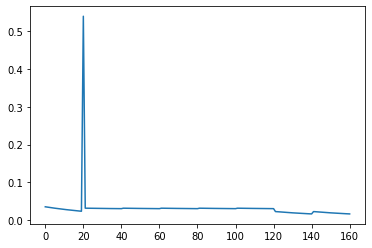

In [903]:
CPS = Cps_OD_neg[::-1] + [Cp_RF] + Cps_OD_pos
Puiss = P_OD_neg[::-1] + [Cp_RF * 0.5 * U_design**3 * rho * Aire_turb] + P_OD_pos
print(TSR_OD_pos)
print(TSR_OD_neg)
plt.figure()
plt.plot(CPS)
plt.show()

In [891]:
Cp_RF

0.5389912388039424